# Это файл с решением задания №4

### Вопрос:
- Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них.    
- А также курсы с самым большим оттоком (ТОП-3). 

### Что значит регистрация и что значит отток
Регистрация – все те, кто зарегался на предмет / семестр / предмет + семестр (не понятно, что означает курс в условии задания).   

Отток – это те, кто дропнулись. Тут сложнее. 
- is_banked: студенты, кто пересдавал предмет (они же дропнулись в прошлом семестре) 
- date_registration != date_registration кол-во незарегистрированных 
- date_unregistration == date_unregistration все кто отменили регистрацию

### Логика действий:
1. Считаем кол-во зареганных студентов: топ 3 предмета, семестра, предмет + семестр 
2. Считаем кол-во дропнутых студентов: 
   - кол-во пересдачников 
   - кол-во незарегистрированных
   - кол-во отменивших регистрацию
3. Считаем отток: топ 3 предмета, семестра, предмет + семестр 
4. Визуальный ответ на общий вопрос: регистрация | отток для топ 3: предмета, семестра, предмета + семестра 

### Либы + настройки для графиков

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(10,8)})


In [13]:
#Качаем дата-сеты
assesments = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/assessments.csv')
courses = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/courses.csv')
student_assesment = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentAssessment.csv')
student_registration = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentRegistration.csv')

#Связываем дата-сеты
courses_reg = pd.merge(courses,student_registration,on=['code_module', 'code_presentation'])
ocenki = pd.merge(courses_reg, assesments,on= ['code_module', 'code_presentation'])
full_ocenki = pd.merge(ocenki, student_assesment,on=['id_assessment', 'id_student'])

# Считаем кол-во зареганных студентов

У многих студентов значение регистрации может повторяться.   
Поэтому вместо числа уникальных регситраций (date_registration) будем считать число уникальных id_student

### Топ 3 предмета по кол-во регистрации 

In [14]:
full_ocenki.groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().sort_values('id_student', ascending = False).head(3)

,code_module,id_student
5,FFF,6058
1,BBB,5960
3,DDD,4699


### Топ 3 семестра по кол-во регистрации 

In [15]:
full_ocenki.groupby(['code_presentation'],as_index = False) \
    ['id_student'].nunique().sort_values('id_student', ascending = False).head(3)

,code_presentation,id_student
3,2014J,8613
1,2013J,7098
2,2014B,5748


### Топ 3 предмета | семестра по кол-во регистрации 

In [16]:
full_ocenki.groupby(['code_module','code_presentation'],as_index = False) \
    ['id_student'].nunique().sort_values('id_student', ascending = False).head(3)

,code_module,code_presentation,id_student
7,CCC,2014J,1998
16,FFF,2013J,1874
18,FFF,2014J,1843


---

# Считаем дропнутых студентов

## Количество пересдачников

In [17]:
full_ocenki.query('is_banked == 1 & date_registration == date_registration & date_unregistration != date_unregistration') \
    .groupby(['code_module', 'code_presentation'],as_index = False) \
    ['id_student'].nunique().id_student.sum()

383

## Студенты, кто не зарегался на предмет 

In [18]:
full_ocenki.query('date_registration != date_registration & is_banked == 0').id_student.nunique()

3

У нас получилось 3 студента, которые не зарегался на предмет регистрацию date_registration != date_registration   
Их количество будет включено в список студентов, кто отменил регистрацию date_unregistration == date_unregistration (не берем их в учет)

## Студенты, кто отменил регистрацию

In [19]:
full_ocenki.query('date_unregistration == date_unregistration & is_banked == 0') \
    .groupby(['code_module', 'code_presentation'],as_index = False) \
    ['id_student'].nunique().id_student.sum()

4563

Общее количество дропнутых студентов = 4946

---

## Топ 3 семестра с самым большим оттоком

In [21]:
#Кол-во зарегистрированных студентов для каждого семестра
registrated_semestr = full_ocenki.groupby(['code_presentation'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_registration'})

#Кол-во пересдачников для каждого семестра
peresdachi_semestr = full_ocenki.query('is_banked == 1 & date_registration == date_registration & date_unregistration != date_unregistration') \
    .groupby([ 'code_presentation'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_peresdachi'})

#Кол-во отменивших регистрацию для каждого семестра
otmena_registration_semestr = full_ocenki.query('date_unregistration == date_unregistration & is_banked == 0') \
    .groupby(['code_presentation'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_otmena'})

#Соединяем 3 дата-сета
merged_1_semestr = registrated_semestr.merge(peresdachi_semestr, on = ['code_presentation'], how="left" ).fillna(0)
ottok_semestr = merged_1_semestr.merge(otmena_registration_semestr, on = ['code_presentation'], how="left")

#Создаем общую колонку – дропнутые студенты: кол-во пересдачников + кол-во отменивших регистрацию для каждого семестра 
ottok_semestr['no_reg'] = ottok_semestr['num_peresdachi'] + ottok_semestr['num_otmena']

#Считаем формулу оттока
ottok_semestr['ottok_percentage'] = round(ottok_semestr['no_reg'] / ottok_semestr['num_registration'],2)

#Сортируем данные по оттоку
ottok_semestr.sort_values(by = 'ottok_percentage', ascending = False).head(3)

,code_presentation,num_registration,num_peresdachi,num_otmena,no_reg,ottok_percentage
2,2014B,5748,86,1137,1223,0.21
3,2014J,8613,158,1671,1829,0.21
0,2013B,3803,26,682,708,0.19


## Топ 3 предмета с самым большим оттоком

In [22]:
#Кол-во зарегистрированных студентов для каждого предмета
registrated_module = full_ocenki.groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_registration'})

#Кол-во пересдачников для каждого предмета
peresdachi_module = full_ocenki.query('is_banked == 1 & date_registration == date_registration & date_unregistration != date_unregistration') \
    .groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_peresdachi'})

#Кол-во отменивших регистрацию для каждого предмета
otmena_registration_module = full_ocenki.query('date_unregistration == date_unregistration & is_banked == 0') \
    .groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_otmena'})

#Соединяем 3 дата-сета
merged_1_module = registrated_module.merge(peresdachi_module, on = ['code_module'], how="left" ).fillna(0)
ottok_module = merged_1_module.merge(otmena_registration_module, on = ['code_module'], how="left")

#Создаем общую колонку – дропнутые студенты: кол-во пересдачников + кол-во отменивших регистрацию для каждого предмета 
ottok_module['no_reg'] = ottok_module['num_peresdachi'] + ottok_module['num_otmena']

#Считаем формулу оттока
ottok_module['ottok_percentage'] = round(ottok_module['no_reg'] / ottok_module['num_registration'],2)

#Сортируем данные по оттоку
ottok_module.sort_values(by = 'ottok_percentage', ascending = False).head(3)

,code_module,num_registration,num_peresdachi,num_otmena,no_reg,ottok_percentage
2,CCC,3318,23,1017,1040,0.31
3,DDD,4699,126,1059,1185,0.25
5,FFF,6058,123,1095,1218,0.20


## Топ 3 предмета | семестра с самым большим оттоком

In [23]:
#Кол-во зарегистрированных студентов для каждого предмета | семестра
registrated = full_ocenki.groupby(['code_module','code_presentation'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_registration'})

#Кол-во пересдачников для каждого предмета | семестра
peresdachi = full_ocenki.query('is_banked == 1 & date_registration == date_registration & date_unregistration != date_unregistration') \
    .groupby(['code_module', 'code_presentation'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_peresdachi'})

#Кол-во отменивших регистрацию для каждого предмета | семестра
otmena_registration = full_ocenki.query('date_unregistration == date_unregistration & is_banked == 0') \
    .groupby(['code_module', 'code_presentation'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_otmena'})

#Соединяем 3 дата-сета
merged_1 = registrated.merge(peresdachi, on = ['code_module', 'code_presentation'], how="left" ).fillna(0)
ottok = merged_1.merge(otmena_registration, on = ['code_module', 'code_presentation'], how="left")

#Создаем общую колонку – дропнутые студенты: кол-во пересдачников + кол-во отменивших регистрацию для каждого предмета 
ottok['no_reg'] = ottok['num_peresdachi'] + ottok['num_otmena']

#Считаем формулу оттока
ottok['ottok_percentage'] = round(ottok['no_reg'] / ottok['num_registration'],2)

#Сортируем данные по оттоку
ottok.sort_values(by = 'ottok_percentage', ascending = False).head(3)


,code_module,code_presentation,num_registration,num_peresdachi,num_otmena,no_reg,ottok_percentage
6,CCC,2014B,1415,0.0,450,450.0,0.32
7,CCC,2014J,1998,23.0,597,620.0,0.31
10,DDD,2014B,944,22.0,245,267.0,0.28


## Общий ответ на вопрос 

Топ 3 предмета по кол-во регистрации 
- FFF
- BBB
- DDD

Топ 3 семестра по кол-во регистрации 
- 2014j
- 2013j
- 2014b

Топ 3 семестр | предмет по кол-во регистрации 
- CCC | 2014j
- FFF | 2013j
- FFF | 2014j


Топ 3 предмета по оттоку
- CCC
- DDD
- FFF

Топ 3 семестра по оттоку
- 2014b
- 2014j
- 2013b

Топ 3 семестр | предмет по оттоку 
- CCC | 2014b
- CCC | 2014j
- DDD | 2014b


# Визуальный ответ на основной вопрос 

### Семестр

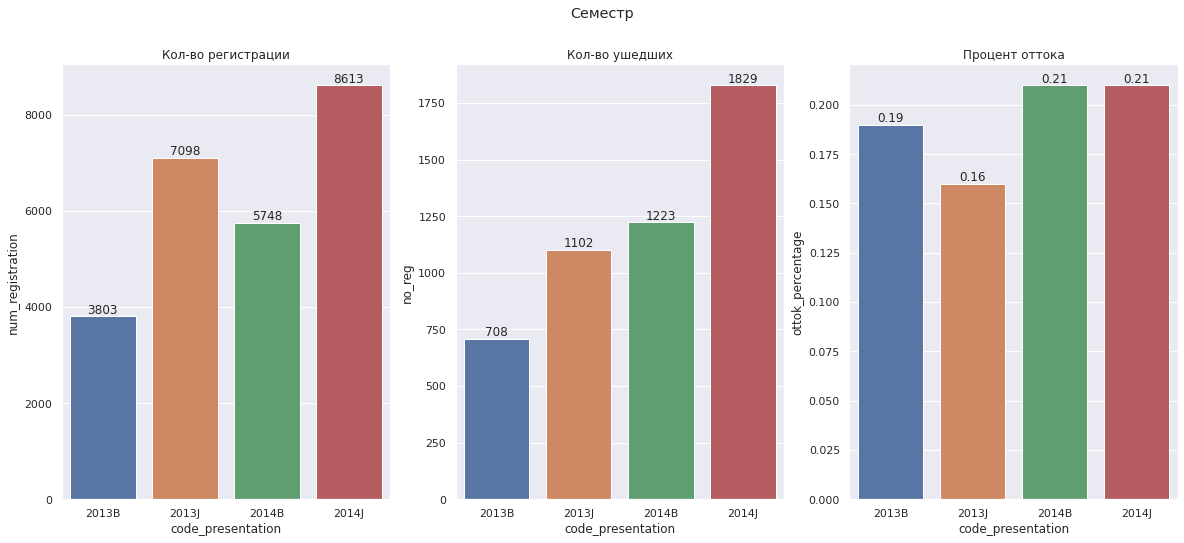

In [24]:
#Создаем 3 рамки для графиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Общее название
fig.suptitle('Семестр')

#Названия для отдельных графиков
axes[0].set_title('Кол-во регистрации')
axes[1].set_title('Кол-во ушедших')
axes[2].set_title('Процент оттока')

#Размер графиков
fig.set_size_inches(20, 8)

#Первый график
graph1 = sns.barplot(ax=axes[0],x="code_presentation", y="num_registration", 
            data=registrated_semestr)

#Подписи для первого графика (цифры над столбцами)
for container in graph1.containers:
    graph1.bar_label(container)

#Второй график
graph2 = sns.barplot(ax=axes[1],x="code_presentation", y="no_reg", 
            data=ottok_semestr)

#Подписи для второго графика (цифры над столбцами)
for container in graph2.containers:
    graph2.bar_label(container)
    
#Третий график    
graph3 =  sns.barplot(ax=axes[2],x="code_presentation", y="ottok_percentage", 
            data=ottok_semestr)

#Подписи для третьего графика (цифры над столбцами)
for container in graph3.containers:
    graph3.bar_label(container)   

### Предмет

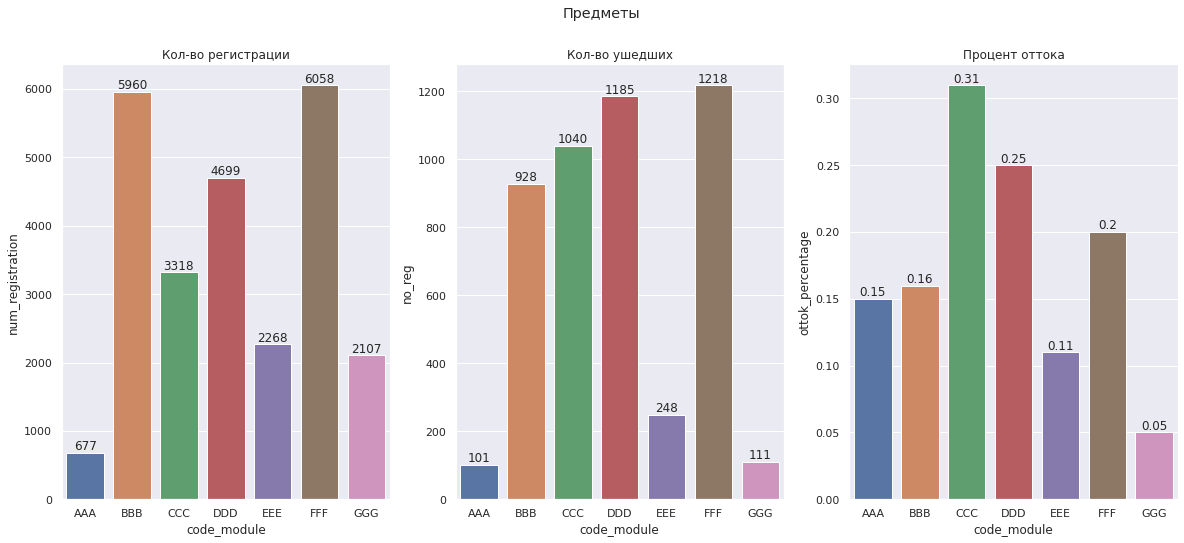

In [25]:
#Создаем 3 рамки для графиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Общее название
fig.suptitle('Предметы')

#Названия для отдельных графиков
axes[0].set_title('Кол-во регистрации')
axes[1].set_title('Кол-во ушедших')
axes[2].set_title('Процент оттока')

#Размер графиков
fig.set_size_inches(20, 8)

#Первый график
graph1 = sns.barplot(ax=axes[0],x="code_module", y="num_registration", 
            data=registrated_module)

#Подписи для первого графика (цифры над столбцами)
for container in graph1.containers:
    graph1.bar_label(container)

#Второй график
graph2 = sns.barplot(ax=axes[1],x="code_module", y="no_reg", 
            data=ottok_module)

#Подписи для второго графика (цифры над столбцами)
for container in graph2.containers:
    graph2.bar_label(container)
    
#Третий график    
graph3 = sns.barplot(ax=axes[2],x="code_module", y="ottok_percentage", 
            data=ottok_module)

#Подписи для третьего графика (цифры над столбцами)
for container in graph3.containers:
    graph3.bar_label(container)

### Семестр | Предмет

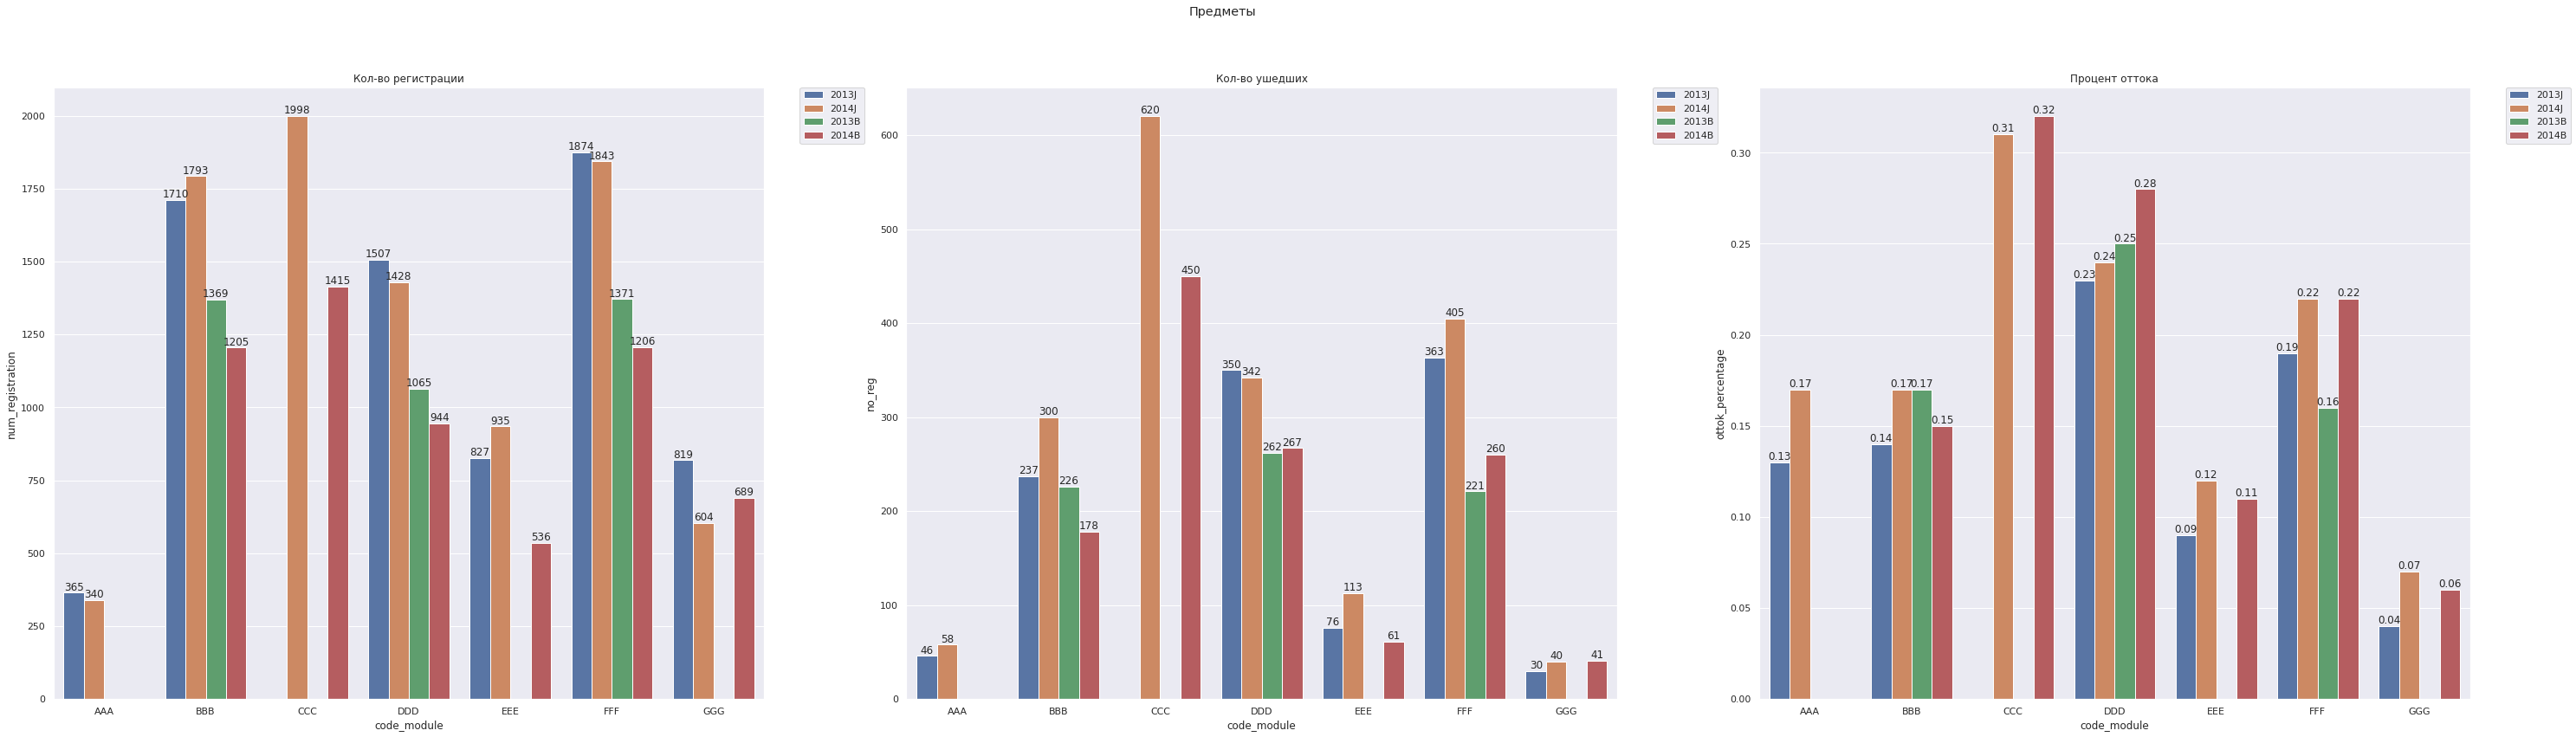

In [26]:
#Создаем 3 рамки для графиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Общее название
fig.suptitle('Предметы')

#Названия для отдельных графиков
axes[0].set_title('Кол-во регистрации')
axes[1].set_title('Кол-во ушедших')
axes[2].set_title('Процент оттока')

#Размер графиков
fig.set_size_inches(50, 13)

#Первый график
graph1 = sns.barplot(ax=axes[0],x="code_module", y="num_registration", 
            data=registrated, hue = 'code_presentation')

#Двигаем легенду
graph1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписи для первого графика (цифры над столбцами)
for container in graph1.containers:
    graph1.bar_label(container)

#Второй график
graph2 = sns.barplot(ax=axes[1],x="code_module", y="no_reg", 
            data=ottok, hue = 'code_presentation')

#Двигаем легенду
graph2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписи для второго графика (цифры над столбцами)
for container in graph2.containers:
    graph2.bar_label(container)

#Третий график 
graph3 = sns.barplot(ax=axes[2],x="code_module", y="ottok_percentage", 
            data=ottok, hue = 'code_presentation')

#Двигаем легенду
graph3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписи для третьего графика (цифры над столбцами)
for container in graph3.containers:
    graph3.bar_label(container)

Сори, что мелко)